In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fiona
import geopandas as gpd
import scipy.sparse
import seaborn as sns

%matplotlib inline

In [2]:
pd.options.display.max_rows = 10

In [3]:
junctions = gpd.read_file('/Users/mdbartos/Data/ellsworth/junctions.shp')
conduits = gpd.read_file('/Users/mdbartos/Data/ellsworth/conduits.shp')
orifices = gpd.read_file('/Users/mdbartos/Data/ellsworth/orifices.shp')
outfalls = gpd.read_file('/Users/mdbartos/Data/ellsworth/outfalls.shp')
storages = gpd.read_file('/Users/mdbartos/Data/ellsworth/storages.shp')
weirs = gpd.read_file('/Users/mdbartos/Data/ellsworth/weirs.shp')

In [4]:
nodes = pd.concat([junctions, storages, outfalls], join='inner').reset_index(drop=True)

In [5]:
links = pd.concat([conduits, orifices, weirs], join='inner').reset_index(drop=True)

In [6]:
nodemap = pd.Series(nodes.index, index=nodes['NAME'])

In [7]:
duplicated = links.duplicated(subset=['INLETNODE', 'OUTLETNODE'])
links = links[~duplicated]

In [8]:
startnodes = nodemap.loc[links['INLETNODE'].values].values
endnodes = nodemap.loc[links['OUTLETNODE'].values].values

In [9]:
assert not (np.isnan(startnodes).any() or np.isnan(endnodes).any())

In [10]:
# Find indegree
indegree = np.bincount(endnodes)
outdegree = np.bincount(startnodes)
forks_end = np.flatnonzero(indegree > 1)
forks_start = np.flatnonzero(outdegree > 1)
# Find fork nodes
is_fork = np.in1d(endnodes, forks_end) | np.in1d(startnodes, forks_start)
# Remove fork nodes
start = startnodes[~is_fork]
end = endnodes[~is_fork]

In [11]:
n = max(start.max(), end.max()) + 1
A = scipy.sparse.lil_matrix((n,n))
for i, j in zip(start, end):
    A[i,j] = 1
n_components, labels = scipy.sparse.csgraph.connected_components(A, directed=True)

In [12]:
# Reorder labels so colors do not clump together on plot
np.random.seed(0)
reorder = np.random.permutation(np.arange(n_components))

In [13]:
nodes['cc'] = reorder[labels]
links['cc'] = reorder[labels][links['INLETNODE'].map(nodemap).values]

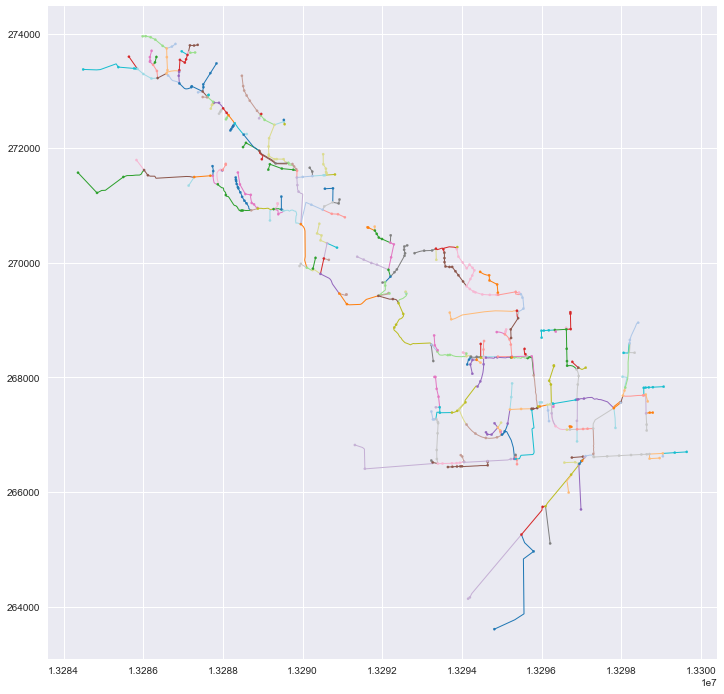

In [14]:
fig, ax = plt.subplots(figsize=(12,12))
nodes.plot(ax=ax, column='cc', cmap='tab20', s=5, alpha=1, zorder=2)
links.plot(ax=ax, column='cc', cmap='tab20', linewidth=1, alpha=1, zorder=1)